<a href="https://colab.research.google.com/github/nikeboke/Device-Driver/blob/main/Boke_VGGMTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import librosa
from sklearn import metrics
from datetime import datetime
from os import mkdir
import pytz
import skimage
from skimage import io
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
v3path = "/content/drive/My Drive/Smart Home/Dataset Collection/EkinNRTakes/"
images_path = "/content/drive/My Drive/Smart Home/Dataset Collection/DatasetV3Images"
gestures = ["Tap", "Swipe Right-Left", "Swipe Right", "Scroll Down", "Circle"]
dirs = os.listdir(v3path)
enum = {g:gestures.index(g) for g in gestures}

In [ ]:
HOP_LENGTH = 512
N_MELS = 128
TIME_STEPS = 512
IMAGE_X = 0
IMAGE_Y = N_MELS

In [ ]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled


In [ ]:
def spectrogram_image(y, sr, out, hop_length, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
    mels = np.log(mels + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy

    IMAGE_X = img.shape[1]
    IMAGE_Y = img.shape[0]

    # save as PNG
    skimage.io.imsave(out, img)
    #fig, ax = plt.subplots()
    #im = ax.imshow(img)

In [ ]:
# this part generates new timestamped folders for recordings
now = datetime.now()
timezone = pytz.timezone('Turkey')
now = now.astimezone(timezone)
dt_string = now.strftime("%d-%m-%Y %H:%M:%S")
count = 0
for f in os.listdir(images_path):
    count = max(count, int(f[0]))
new_dir = images_path + "/" + str(count+1) + " - Created at " + dt_string
os.mkdir(new_dir)
for g in gestures:
  os.mkdir(new_dir + "/" + g)

os.chdir(new_dir)

In [ ]:
for dir in dirs:
  folder_path = v3path + "/" + dir
  recordings = os.listdir(folder_path)
  for recording in recordings:
    rec_path = folder_path + "/" + recording

    # settings
    hop_length = HOP_LENGTH # number of samples per time-step in spectrogram
    n_mels = N_MELS # number of bins in spectrogram. Height of image
    time_steps = TIME_STEPS # number of time-steps. Width of image
    # Keep halving the values until it works!


    # load audio.
    y, sr = librosa.load(rec_path, offset=0.5, duration=10.0, sr=44100)

    out_dir = os.getcwd() + "/" + dir
    if not os.path.exists(out_dir):
      os.makedirs(out_dir)
    out = out_dir + "/" + recording[:-4] + ".png"

    # extract a fixed length window
    start_sample = 0 # starting at beginning
    length_samples = time_steps*hop_length
    window = y[start_sample:start_sample+length_samples]

    # convert to PNG
    spectrogram_image(window, sr=sr, out=out, hop_length=hop_length, n_mels=n_mels)
    print('wrote file', out)

wrote file /content/Swipe Right/ekin0 SR1.png
wrote file /content/Swipe Right/ekin0 SR2.png
wrote file /content/Swipe Right/ekin3 SR1.png
wrote file /content/Swipe Right/ekin3 SR2.png
wrote file /content/Swipe Right/ekin4 SR1.png
wrote file /content/Swipe Right/ekin4 SR2.png
wrote file /content/Swipe Right/ekin5 SR1.png
wrote file /content/Swipe Right/ekin5 SR2.png
wrote file /content/Swipe Right/ekin6 SR1.png
wrote file /content/Swipe Right/ekin6 SR2.png
wrote file /content/Swipe Right/ekin7 SR1.png
wrote file /content/Swipe Right/ekin7 SR2.png
wrote file /content/Swipe Right/ekin8 SR1.png
wrote file /content/Swipe Right/ekin8 SR2.png
wrote file /content/Swipe Right/ekin9 SR1.png
wrote file /content/Swipe Right/ekin9 SR2.png
wrote file /content/Swipe Right/ekin10 SR1.png
wrote file /content/Swipe Right/ekin10 SR2.png
wrote file /content/Swipe Right/ekin11 SR1.png
wrote file /content/Swipe Right/ekin11 SR2.png
wrote file /content/Swipe Right/ekin12 SR1.png
wrote file /content/Swipe Rig

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import librosa
from sklearn import metrics
from datetime import datetime
from os import mkdir
import pytz
import skimage
from skimage import io
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from keras.utils import to_categorical
plt.style.use('fivethirtyeight')
import imageio
import glob

In [ ]:
v3path = "/content/drive/My Drive/Smart Home/Dataset Collection/EkinNRTakes/"
images_path = "/content/drive/My Drive/Smart Home/Dataset Collection/DatasetV3Images"
gestures = ["Tap", "Swipe Right-Left", "Swipe Right", "Scroll Down", "Circle"]

In [ ]:
# get the directory with the biggest number (I assume it is the most accurate)
last_dir = os.path.join(images_path, (sorted(os.listdir(images_path))[-1]))
print(last_dir)
os.chdir(last_dir)

/content/drive/.shortcut-targets-by-id/1auEKtFcKniNDliDPVeLVA1DUXuRKupzo/Smart Home/Dataset Collection/DatasetV3Images/5 - Created at 17-12-2020 11:01:26/Tap


In [ ]:
images_path = os.getcwd()

In [ ]:
img_dirs = os.listdir(images_path)
img_dirs

['Tap', 'Swipe Right-Left', 'Swipe Right', 'Scroll Down', 'Circle']

In [ ]:
!pip install pillow

In [ ]:
batch_size = 10
img_height = 128
img_width = 44
# It should have exactly 3 input channels, and width and height should be no smaller than 32.

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import vgg16

In [ ]:
# Create training dataset.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        images_path,
        validation_split=0.2,
        subset="training",
        seed=13,
        #color_mode = 'grayscale',
        color_mode = 'rgb',
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=True,
        )

print(train_ds)

#Note: each Keras Application expects a specific kind of input preprocessing. For VGG16, call tf.keras.applications.vgg16.preprocess_input on your inputs before passing them to the model.

Found 419 files belonging to 5 classes.
Using 336 files for training.
<BatchDataset shapes: ((None, 128, 44, 3), (None,)), types: (tf.float32, tf.int32)>


In [ ]:
# Create validation dataset.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  images_path,
  validation_split=0.2,
  subset="validation",
  seed=12,
  color_mode = 'rgb',
  image_size=(img_height, img_width),
  shuffle=True,
  batch_size=batch_size)

Found 419 files belonging to 5 classes.
Using 83 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Circle', 'Scroll Down', 'Swipe Right', 'Swipe Right-Left', 'Tap']


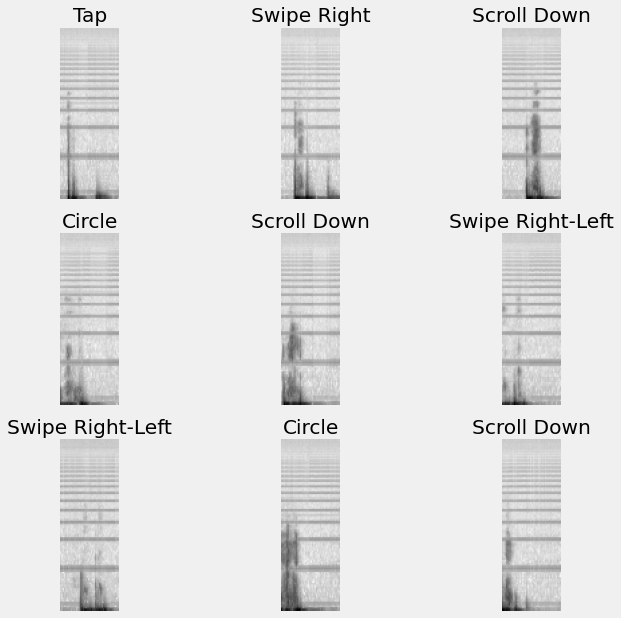

In [ ]:
# Show the first 9 instances of the training set.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  #for i in range(9):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8").reshape(img_height, img_width,3))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 128, 44, 3)
(10,)


In [ ]:
# This is for easy IO.
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 5
input_shape = (128,44,3)



In [ ]:
model = VGG16(weights="imagenet",include_top=False, input_shape = input_shape)
model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-1].output)
model.trainable = False

def pretrained_model(img_shape, num_classes):
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
    #model_vgg16_conv.summary()

    #Create your own input format
    keras_input = Input(shape=img_shape, name = 'image_input')

    #Use the generated model
    output_vgg16_conv = model_vgg16_conv(keras_input)

    #Add the fully-connected layers
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4096, activation=layer_type, name='fc1')(x)
    x = Dense(4096, activation=layer_type, name='fc2')(x)
    x = Dense(num_classes, activation='softmax', name='predictions')(x)

    #Create your own model
    pretrained_model = Model(inputs=keras_input, outputs=x)
    pretrained_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return pretrained_model

flat1 = Flatten()(model.layers[-1].output)
#class1 = Dense(256, activation='relu')(flat1)
#dropout1 = Dropout(0.4)(class1)
#class2 = Dense(256, activation='relu')(dropout1)
#dropout2 = Dropout(0.4)(class2)
#class3 = Dense(256, activation='relu')(dropout2)
#output = Dense(num_classes, activation='softmax')(class3)
#model = tf.keras.Model(inputs=model.inputs, outputs=output)
class1 = Dense(512, activation='relu')(flat1)
dropout1 = Dropout(0.5)(class1)
class2 = Dense(512, activation='relu')(dropout1)
#dropout2 = Dropout(0.4)(class2)
#class3 = Dense(256, activation='relu')(dropout2)
output = Dense(num_classes, activation='softmax')(class2)
model = tf.keras.Model(inputs=model.inputs, outputs=output)




for layer in model.layers:
  print(layer.trainable)


print(model.summary())

58892288/58889256 [==============================] - 0s 0us/step
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 44, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 44, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 44, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 22, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 22, 128)       73856     
_____________________________________________________

In [ ]:
flat1 = Flatten()(model.layers[-1].output)
#class1 = Dense(256, activation='relu')(flat1)
#dropout1 = Dropout(0.4)(class1)
#class2 = Dense(256, activation='relu')(dropout1)
#dropout2 = Dropout(0.4)(class2)
#class3 = Dense(256, activation='relu')(dropout2)
#output = Dense(num_classes, activation='softmax')(class3)
#model = tf.keras.Model(inputs=model.inputs, outputs=output)
class1 = Dense(256, activation='relu')(flat1)
#dropout1 = Dropout(0.4)(class1)
class2 = Dense(256, activation='relu')(class1)
#dropout2 = Dropout(0.4)(class2)
class3 = Dense(128, activation='relu')(class2)
class4 = Dense(128, activation='relu')(class3)
dropout1 = Dropout(0.5)(class4)
output = Dense(num_classes, activation='softmax')(dropout1)
model = tf.keras.Model(inputs=model.inputs, outputs=output)

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
  #optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history = model.fit( train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50
34/34 [==============================] - 96s 3s/step - loss: 6.9219 - accuracy: 0.2696 - val_loss: 1.5390 - val_accuracy: 0.5301
Epoch 2/50
34/34 [==============================] - 0s 14ms/step - loss: 3.9640 - accuracy: 0.4264 - val_loss: 1.5789 - val_accuracy: 0.6506
Epoch 3/50
34/34 [==============================] - 0s 14ms/step - loss: 3.0341 - accuracy: 0.5036 - val_loss: 1.4672 - val_accuracy: 0.6386
Epoch 4/50
34/34 [==============================] - 0s 14ms/step - loss: 2.3342 - accuracy: 0.5547 - val_loss: 1.1279 - val_accuracy: 0.7229
Epoch 5/50
34/34 [==============================] - 0s 14ms/step - loss: 1.6897 - accuracy: 0.6471 - val_loss: 0.6256 - val_accuracy: 0.7470
Epoch 6/50
34/34 [==============================] - 0s 15ms/step - loss: 1.8143 - accuracy: 0.6313 - val_loss: 0.5521 - val_accuracy: 0.8434
Epoch 7/50
34/34 [==============================] - 0s 15ms/step - loss: 1.2803 - accuracy: 0.7140 - val_loss: 0.5401 - val_accuracy: 0.8313
Epoch 8/50
34/

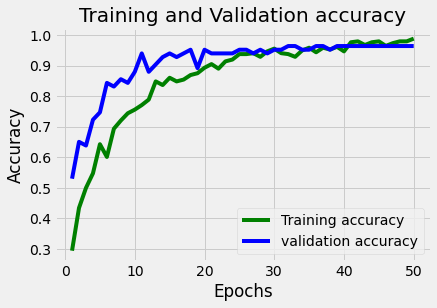

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#visualize weights
#!pip install https://github.com/raghakot/keras-vis/archive/master.zip

In [ ]:
model.save('/content/drive/My Drive/Smart Home/BOKE2_VGG-MODEL.h5')